# Improting libraries

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from time import process_time
import re
import pandas as pd
from scipy import linalg

To perform the experiments you first call the 'create_functions', then you will feed 'objective' and 'gradient' to the functions of the optimization algorithms. Gradient and objective will be to function where the regularization term is specified when create_functions is called. So when called inside the opt algorithms they just need xt. 

Below there are all the functions that are called inside the opt. alg. The arguments were specified in every function, but actually it is not necessary because every variable is declared inside the o. a. I leave these arguments so that each of those functions can be easily tested outside the function. But if everything works, you can consider to remove the arguments

# Lipk and sz

In [16]:

def LMO(simplex, gradient_xt): 
    sti = np.argmin(simplex @ gradient_xt) ## the gradient(xt)
    st = simplex[sti] 
    return st, sti


def lipk_and_sz(Q, x_t, f_x, g, gamma_max, d_t, x0, L):
    
    if type(x0) == int:
        x0 = x_t 
        #print("x0:", x0)
    epsilon = 10e-3
    k1 = 0.9
    k2 = 2
    nL = k1 * L
    clip = g ** 2 / (2 * (objective(x0) - f_x) * d_t.T @ d_t)
    #print("print clip: ", clip) ## clip should not be zero
    M = np.clip(clip ,nL, L) ## the function clip is bounded by upper bound nL and lower bound L
    #print("M:", M)
    bound = g / (M * np.linalg.norm(d_t)) #d_t.T @ d_t
    gamma = min(bound, gamma_max)
    #print("gamma:", gamma)
    while objective(x_t + (gamma * d_t)) > (f_x - (gamma * g) + ( (gamma ** 2) * M) * (d_t.T @ d_t)) :
        M = k2 * M
        bound = g / (M * np.linalg.norm(d_t)) #d_t.T @ d_t
        #print("Updating M:", M)
        gamma = min(bound, gamma_max)
    return gamma, bound, M


In [17]:
def c_gamma1(xt, fx, gamma_max, gt, dt):
    gamma = gamma_max
    p = 0.1*(-gt)
    f= objective(xt + gamma * dt)
    while (f > (fx + gamma * p)):
      gamma=0.5*gamma
      f = objective(xt + gamma * dt)
    return gamma
    

In [18]:
def get_auxiliary_stepsize(gamma_bound, x_t, y_j, g, d, L=1e-2):
    if objective(y_j + gamma_bound*d) <= objective(y_j): 
        return gamma_bound
    else:
        gamma_bound = 0
        return gamma_bound

# FW Away step with Lipschiz Step

In [19]:
def FW_AS_correct(objective,  gradient, Q, N, start_weights, max_iter = 1000): 
    eps = 1e-6
    active_set = N  
    weights = start_weights
    xt  = active_set @ weights
    for i in range(max_iter):
        if i==0:
            x0 = 1
            L = 1
        fxt = objective(xt)
        g = gradient(xt)
        st, sti = LMO(active_set, g)
        dfw = st - xt
        vti = np.argmax(active_set @ g)
        vt = active_set[vti]
        #print("vt : {}".format(vt))
        daw = xt - vt
        gfw =   -g @ dfw
        gaw =   -g @ daw        
        #print('gfw :', gfw, 'gaw :', gaw)
        if  gfw <= eps: #check the sign of the gradient (or the sign of the gap)
            return [xt, active_set, fxt, "FW_AS", i]
        ## ========================================================================     
        if gfw >= gaw:
            gamma_max=1
            ##Q, x_t, f_x, g, gamma_max, d_t, x0=0, L=0
            gamma = c_gamma1(xt, fxt, gamma_max, gfw, dfw)
            # this is required by the the function lipk_and_sz, because at every call of this function we need to feed xt and xt-1
            x0 = xt 
            xt += gamma * dfw
            weights = (1-gamma) * weights
            #problem? #this shouldn't be a problem because weights'd be a matrix and in this way you'd update one row
            weights[sti] += gamma 
            if (gamma == 1):
                active_set= st
                weights = weights[sti]
            else:
                active_set = np.vstack((active_set, st))
                weights = np.hstack((weights, gamma))
        ## ========================================================================  
        else:
            weight_v_t = weights[vti]
            # in this case the weights should not be one. if the weights are equal to one then gamma-max is equal to one as well
            gamma_max = weight_v_t / (1 - weight_v_t) 
            gamma = c_gamma1(xt, fxt, gamma_max, gaw, daw)
            # this is required by the the function lipk_and_sz, because at every call of this function we need to feed xt and xt-1
            x0 = xt 
            xt += gamma * daw
            weights = (1 + gamma) * weights 
            #problem? #this shouldn't be a problem because weights'd be a matrix and in this way you'd update one row
            weights[vti] -= gamma 
            if gamma == gamma_max:
                active_set = np.delete(active_set, vti, 0) 
                weights = np.delete(weights, vti)
    return [xt, active_set, fxt, "FW_AS", i]



# FW Away step Short Step chain 

In [20]:
def FW_AS_SSC_correct(objective,  gradient, Q, N, start_weights,  max_iter=1000, max_iter_ssc=1000): 
    eps = 1e-6
    active_set=N
    weights = start_weights
    xt  = active_set @ weights
    for i in range(max_iter):
        g = gradient(xt)
        if i==0:
            x0=0
            L=1e-1
        st, sti = LMO(active_set, g) #defined
        dfw = st - xt
        vti = np.argmax(active_set @ g)
        vt = active_set[vti]
        daw = xt - vt
        
        gfw =  - g @ dfw
        fxt = objective(xt)
        if gfw <= eps: #check the sign of the gradient (or the sign of the gap)
            return [xt, active_set, fxt, "FW_AS_SCC", i] 
        e_j = active_set
        y_j = xt
        g_y_j = gradient(y_j)
        y0=x0
        for j in range(max_iter_ssc):
            
            fx = objective(y_j)
            st, sti = LMO(e_j, g) #defined
            dfw = st - y_j
            vti = np.argmax(e_j @ g)
            vt = e_j[vti]
            daw = y_j - vt
            dfw = st - y_j
            gaw = - g @ daw
            gfw =  - g_y_j @ dfw
            if gfw  <= eps:
                return [xt, active_set, fxt, "FW_AS_SCC", i]
            if gfw >= gaw:
                gammamax=1
                
                gamma, gamma_bound, L = lipk_and_sz(Q, y_j, fx, gfw, gammamax, dfw,  y0, L)
                gamma_bound = get_auxiliary_stepsize(gamma_bound, xt, y_j, g, dfw, L)
                gamma = min(gamma_bound, gammamax)
                if dfw@dfw.T == 0:
                    break
                if gamma_bound <=0:
                    break
                #gamma_bound = get_auxiliary_stepsize(Q, xt, y_j, - g_y_j, dfw, L) #d_j -> dfw ??
                #gamma = min(gammamax, gamma_bound)# gamma_bound)
                weights = (1-gamma) * weights
                weights[sti] += gamma #problem? #this shouldn't be a problem because weights'd be a matrix and in this way you'd update one row
                y0=y_j
                y_j += gamma*dfw
                if (gamma == 1):
                    e_j = st
                    weights = weights[sti]
                else:
                    e_j = np.vstack((e_j, st))
                    weights = np.hstack((weights, gamma))
            else:
                weight_v_t = weights[vti]
                gamma_max = weight_v_t / (1 - weight_v_t)
                gamma, gamma_bound, L = lipk_and_sz(Q, y_j, fx, gaw, gamma_max, daw,  y0, L)
                gamma_bound = get_auxiliary_stepsize(gamma_bound, xt, y_j, g, daw, L)
                gamma = min(gamma_bound, gamma_max)
                if daw@daw.T == 0:
                    break
                if gamma_bound <=0:
                    break
                y0=y_j
                y_j += gamma*daw
                weights = (1+gamma) * weights
                #problem? #this shouldn't be a problem because weights'd be a matrix and in this way you'd update one row
                weights[vti] -=gamma 
                if gamma == gamma_max:
                    e_j = np.delete(e_j, vti, 0) 
                    weights = np.delete(weights, vti)
            if gamma_bound == gamma:
                break
            else:
                continue
        active_set = e_j
        x0 = xt
        xt=y_j
    return [xt, active_set, fxt, "FW_AS_SCC", i]

# FW Pair Wise with Lipschiz Step

In [21]:
def FW_PW_correct(objective,  gradient, Q, N, start_weights, max_iter = 1000):
    eps = 1e-6
    active_set=N
    weights = start_weights
    xt  = active_set @ weights
    for i in range(max_iter):
        if i==0:
            x0=0
            L=1
        g  = gradient(xt)
        fxt  = objective(xt)
        st, sti = LMO(active_set, g) #defined
        vti = np.argmax(active_set @ g)
        vt = active_set[vti]# gradient is a fucntion itself
        dt = st - vt
        gfw =  - g @ dt
        if gfw <= eps:
            return [xt, active_set, fxt, "FW_PW", i]
        gamma_max = weights[vti]
        gamma = c_gamma1(xt, fxt, gamma_max, gfw, dt)
        weights[vti] -= gamma
        weights[sti] += gamma
        if (abs(weights[vti]) <= 0.00001):
            active_set = np.delete(active_set, vti, 0)
            weights = np.delete(weights, vti)
        x0=xt
        xt += gamma*dt
    return [xt, active_set, fxt, "FW_PW", i]

# FW Pair Wise with Short Step Chain

In [22]:
#not touch for for any reason
def FW_PW_SSC_correct(objective,  gradient, Q, N, start_weights,   max_iter=1000, max_iter_ssc=1000): 
    eps = 1e-6
    active_set=N
    weights = start_weights
    xt  = active_set @ weights
    for i in range(max_iter):
        if i==0:
            x0=0
            L=1
        g = gradient(xt)
        fxt = objective(xt)
        st, sti = LMO(active_set, g) #defined
        vti = np.argmax(active_set @ g)
        vt = active_set[vti]
        dt = st - vt
        gfw =  - g @ dt
        if gfw  <= eps:
            [xt, active_set, fxt, "FW_PW_SSC", i]
        e_j = active_set
        y_j = xt
        y0=x0
        for j in range(max_iter_ssc):
            #print('ssc iteration :', j)
            st, sti = LMO(e_j, g) #defined
            fx=objective(y_j)
            #g_y_j = gradient(y_j)
            vti = np.argmax(e_j @ g)
            vt = e_j[vti]
            dt = st - vt
            gfw =  -g @ dt
            if gfw  <= eps:
                return [y_j, e_j, fx, "FW_PW_SSC", i]
            gammamax = weights[vti]
            gamma, gamma_bound, L = lipk_and_sz(Q, y_j, fx, gfw, gammamax, dt,  y0, L)
            gamma_bound = get_auxiliary_stepsize(gamma_bound, xt, y_j, g, dt, L)
            if (gamma_bound <= 0):
                break
            gamma = min(gammamax, gamma_bound)
            y0=y_j
            y_j += gamma*dt
            weights[vti] -= gamma
            weights[sti] += gamma
            if (abs(weights[vti]) <= 0.00001):
                e_j = np.delete(e_j, vti, 0)
                weights = np.delete(weights, vti)
            
            
            if gamma_bound == gamma:
                break
        active_set = e_j
        x0=xt
        xt=y_j
    return [xt, active_set, fx, "FW_PW_SSC", i]
        

# Data Set

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
dimacs_dir_path = "/content/drive/MyDrive/Dimacs/dimacs/"
to_be_tested = "/content/drive/MyDrive/Dimacs/dimacs/to_be_tested"

# Check Clique

In [25]:
def check_clique(Q, x):
    print("print x: ", x)
    findx, = np.where(abs(x)>1e-3)
    print("print findx: ",findx)
    c = findx.size
    v = abs(sum(sum(-Q[findx][:, findx])) + c*(2*(c-1)+1))
    print("Check clique:", c, v)
    return v<0.1, c

# Load_Dimacs_Graphs

In [26]:
# ================================================================
# This part is for preprocessing the graphs given to matrices 
def load_dimacs_graph(name):
    t0 = process_time()
    f = open(dimacs_dir_path + name, 'r') 
    edges = []
    N, M, m, n = 0, 0, 0, 0
    t1 = process_time()
    rows = f.readlines()
    t2 = process_time()
    for row in rows:
        args = row.split()
        if (not N):
            if (len(args) >= 4) and (args[0] == "p"):
                n, m = int(args[2]), int(args[3])
                N = max(N, n)
                M = m
        if (len(args) >= 3) and (args[0] == "e"):
            v1, v2 = int(args[1]), int(args[2])
            edges.append((v1, v2))
            N = max(N, v1, v2)
    print("Loading %s: Control Loading" % name, (n == N), (m == M), (M == len(edges)))
    t3 = process_time()
    Q = np.eye(N)
    for v1, v2 in edges:
        Q[v1 - 1, v2 - 1] = 2
        Q[v2 - 1, v1 - 1] = 2
    del row, edges
    c = np.zeros(N)
    t4 = process_time()
    return Q, c, N, M, (t0, t1, t2, t3, t4)

# Create Functions

In [27]:
# This part is where we define objective functions and gradients 
# If we want to use this optimization algorithms for other continuous optimization problems we have to change this part 
def create_functions(Q, c, N, regularization=0, alpha1=0, alpha2=0): # I don't remeber why those default values for alpha1 and 2
    dim = N
    al1_up = 2 / (6 * (1 + 10 ** (-9)))               # the rules for al1 and al2 have been taken from the paper 
    al2_up = 2 / 25                                   # of the max clique 
    if alpha1 < 0 or alpha1 > al1_up:
        alpha1 = np.random.uniform(low=0, high=al1_up)
    if alpha2 < 0 or alpha2 > al2_up:
        alpha2 = np.random.uniform(low=0, high=al2_up)

    def objective(x):
        term = 0.0
        eps = (10 ** (-9)) * np.ones(x.shape)
        if regularization == 0:
            term = 0.0
        #if regularization == 1:
            #term = 1 / 2 * np.sum(x * x)
        elif regularization == 1:
            term = alpha1 * np.sum((x + eps) ** 3)
        elif regularization == 2:
            term = alpha2 * np.sum(np.exp(- 5 * x) - 1)
        fun = x.T @ (Q @ x)
        obj =  -1 / 2 * x.T @ (Q @ x) - term
        return obj

    def gradient(x): 
        gt = 0.0     
        eps = (10 ** (-9)) * np.ones(x.shape) 
        if regularization == 0:
            gt = 0.0
        #if regularization == 1:
            #gt = np.sum(x)  ###########
        elif regularization == 1:
            gt = (alpha1 * 3) * np.sum((x + eps) ** 2)
        elif regularization == 2:
            gt = -5*alpha2 * np.sum(np.exp(- 5 * x))
        fun = Q @ x
        gr =  -fun - gt
        return gr

    return objective, gradient

# Testing Part

In [28]:
t_test = process_time()
algo_list = []
algo_list.append(FW_AS_correct)
algo_list.append(FW_PW_correct)
algo_list.append(FW_PW_SSC_correct)
algo_list.append(FW_AS_SSC_correct)

algo_names = ["FW_Away", "FW_PW", 
              "SSC_PW","SSC_Away"]
np.set_printoptions(threshold=100)

reg_list = ["phi1", "phi2"]
# ==================================================
# This part of the code is for testing
test_name_list_file = open(to_be_tested)
test_name_list = test_name_list_file.read().split()
test_name_list_file.close()

test_name_list = test_name_list[:10]
print("Test list: ", test_name_list)
test_results = {}
test_results_reg = {}
error_list = []

for reg in range(len(reg_list)):  # for faster runs change to range(1,3)
    for test_name in test_name_list:  # 
        if (test_name[0] == "#"):
            continue
        print("*" * 40 + "\nRunning test %s\n" % test_name + "*" * 40)
        Q , c, N, M, times = load_dimacs_graph(test_name + ".clq")
        simplex=np.eye(N)
        print("regularization_term: ", reg_list[reg])
        objective, gradient = create_functions(Q, c, N, regularization=reg + 1)
        # ===================================================================================
        times = {algo_name: [] for algo_name in algo_names}
        clique_nums = {algo_name: [] for algo_name in algo_names}
        iteration_nums = {algo_name: [] for algo_name in algo_names}
        ############ ====================================================================================
        for i in range(0, 10):
            print("===\nExecution #%02d\n===" % i)
            np.random.seed(i)
            w = np.random.rand(simplex.shape[0])
            start_weights = w / sum(w)
            start_indexes = np.arange(0, N)
            ##==========================================================
            for i, ALG in enumerate(algo_list):
                print(algo_names[i])
                t0 = process_time()
                x, cv, fx, status, iterations = ALG(objective, gradient, Q, simplex, start_weights, max_iter = 1000)
                t1 = process_time()
                delta_t = t1 - t0
                result = x, cv, fx, status 
                check, cliq_num = check_clique(Q, x)
                if (check):
                    print("Is correct")
                else:
                    print("Is NOT correct")
                print(x, fx, "\n")
                times[algo_names[i]].append(delta_t)
                clique_nums[algo_names[i]].append(cliq_num)
                iteration_nums[algo_names[i]].append(iterations)
        test_results[test_name] = {"cpu_time": times, "clique_number": clique_nums, "iteration_number": iteration_nums}
            ##==========================================================
        for i, ALG in enumerate(algo_list):
            print(algo_names[i])
            print(clique_nums[algo_names[i]], sum(clique_nums[algo_names[i]]) / 10)
            print(times[algo_names[i]], sum(times[algo_names[i]]) / 10)
            print(iteration_nums[algo_names[i]], sum(iteration_nums[algo_names[i]]) / 10)
        test_results[test_name] = {"cpu_time": times, "clique_number": clique_nums, "iteration_number": iteration_nums}
    test_results_reg[reg_list[reg]] = test_results
    test_results = {}
t_test1 = process_time()
print(t_test1 - t_test)

Test list:  ['brock200_2', 'brock200_4', 'brock400_2', 'C125.9', 'C250.9', 'C500.9', 'DSJC500_5', 'gen200_p0.9_44', 'gen200_p0.9_55', 'gen400_p0.9_55']
****************************************
Running test brock200_2
****************************************
Loading brock200_2.clq: Control Loading True True True
regularization_term:  phi1
===
Execution #00
===
FW_Away
print x:  [ 6.87795763e-19 -3.77653150e-19  6.62808139e-20 ...  1.13061643e-19
 -1.39332455e-20  7.10819125e-19]
print findx:  [ 48  60  81  86  89  91 101 107 112 194]
Check clique: 10 0.0
Is correct
[ 6.87795763e-19 -3.77653150e-19  6.62808139e-20 ...  1.13061643e-19
 -1.39332455e-20  7.10819125e-19] -0.9499999999976401 

FW_PW
print x:  [0.         0.         0.         ... 0.         0.         0.11111116]
print findx:  [  9  37  48  72  93 133 181 185 199]
Check clique: 9 0.0
Is correct
[0.         0.         0.         ... 0.         0.         0.11111116] -0.9444444444440375 

SSC_PW


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


Streaming output truncated to the last 5000 lines.
  2.94111681e-02 -1.23344002e-18]
print findx:  [  3  16  18  27  36  38  43  47  48  49  50  51  52  64  68  69  74  78
  82  87  90  94 105 125 132 139 155 161 165 174 177 178 196 198]
Check clique: 34 0.0
Is correct
[ 3.93407164e-20  1.87253109e-18  4.43091237e-19 ...  0.00000000e+00
  2.94111681e-02 -1.23344002e-18] -0.9852941176430876 

FW_PW
print x:  [0.         0.02857145 0.         ... 0.         0.02857139 0.        ]
print findx:  [  1   4  18  22  23  27  38  48  49  50  52  68  69  74  78  83  85  87
  90  94 105 124 125 132 140 144 155 158 161 165 177 178 189 192 198]
Check clique: 35 0.0
Is correct
[0.         0.02857145 0.         ... 0.         0.02857139 0.        ] -0.9857142857130664 

SSC_PW
print x:  [0.         0.04520256 0.         ... 0.         0.02630015 0.        ]
print findx:  [  1   3   4   6  18  22  23  27  28  34  37  38  44  48  49  50  52  60
  67  68  69  74  78  81  83  85  90  94 103 105 118 124 1

# Output to table 

In [29]:
# output_to_json()
# ==================================================
# This is the part we run to show different cpu times in different algorithms and compare results 
table_latex = ""
test_table = []
test_table_better = []
test_table_better_reg = []
test_names = []


for regular in test_results_reg:
    for test_name in test_results_reg[regular]:
        result = test_results_reg[regular][test_name]
        data_to_show_str = [test_name.replace("_", "\\_")]
        data_to_show = []
        data_to_show_better = []
        test_name_reg = test_name + " " + regular
        test_names.append(test_name_reg)
        for alg_label in result["clique_number"]:
            p = 4
            d = []
            clique_number = np.array(result["clique_number"][alg_label])
            cpu_time = np.array(result["cpu_time"][alg_label])
            iteration = np.array(result["iteration_number"][alg_label])
            v = [
                min(clique_number),
                np.mean(clique_number),
                max(clique_number),
                np.std(clique_number),
                min(cpu_time)
            ]
            vbetter = [min(clique_number),
                       np.mean(clique_number),
                       max(clique_number),
                       np.std(clique_number),
                       np.mean(cpu_time),
                       ]  
            d[0:2] = [str(v[0]), "%.1f" % v[1], str(v[2])]
            d[3:5] = ["%.2f" % l for l in v[3:5]]
            data_to_show_better += vbetter
            data_to_show += v
            data_to_show_str += d
        test_table_better.append(data_to_show_better)
        test_table.append(data_to_show)
        table_latex += " & ".join(data_to_show_str) + " \\\\\n"
print(len(test_table_better))
clmsbetter = ['min clique', 'mean clique', 'max clique', 'std clique',
              'cpu time']
clms = ['min clique', 'mean clique', 'max clique', 'std clique',
        'min cpu time']

muxbetter = pd.MultiIndex.from_product([algo_names, clmsbetter]) 
dfbetter = pd.DataFrame(test_table_better, index=test_names, columns=muxbetter)

mux = pd.MultiIndex.from_product([algo_names, clmsbetter]) 
df = pd.DataFrame(test_table, index=test_names, columns=mux)

#with open('test_reg.txt', 'w') as f:
#    f.write(dfbetter.to_string())
#display(dfbetter)

with open('table_latex.txt', 'w') as f:
    f.write(table_latex)
#print(table_latex)

with open('df.txt', 'w') as f:
    f.write(df.to_string())

print([sublist[:5] for sublist in test_table])

df0 = pd.DataFrame([sublist[:5] for sublist in test_table], index=test_names, columns=clmsbetter)

df1 = pd.DataFrame([sublist[5:10] for sublist in test_table], index=test_names, columns=clmsbetter)
 
df2 = pd.DataFrame([sublist[10:15] for sublist in test_table], index=test_names, columns=clmsbetter)

df3 = pd.DataFrame([sublist[15:20] for sublist in test_table], index=test_names, columns=clmsbetter)
display(df0.to_latex())
display(df1.to_latex())
display(df2.to_latex())
display(df3.to_latex())

20
[[8, 9.1, 10, 0.7000000000000001, 0.33512453799999875], [13, 13.3, 14, 0.45825756949558394, 0.2793069219999893], [19, 20.9, 22, 1.3, 1.0904894340000055], [29, 31.1, 34, 1.374772708486752, 0.33612384299999576], [38, 39.9, 43, 1.57797338380595, 0.7506790609999712], [47, 48.3, 50, 1.0999999999999999, 2.7006482390000315], [10, 10.7, 12, 0.6403124237432849, 1.278282900000022], [33, 34.9, 37, 1.445683229480096, 0.47121413499996834], [36, 37.9, 39, 0.9433981132056604, 0.5410982990000548], [43, 45.2, 47, 1.2489995996796797, 1.7665315170000895], [8, 9.1, 10, 0.7000000000000001, 0.18743160700000772], [13, 13.3, 14, 0.45825756949558394, 0.2347450760000811], [19, 20.9, 22, 1.3, 0.9591387350000105], [29, 31.1, 34, 1.374772708486752, 0.27843991700001425], [38, 39.9, 43, 1.57797338380595, 0.6330881380000619], [47, 48.3, 50, 1.0999999999999999, 2.392614128999867], [10, 10.7, 12, 0.6403124237432849, 1.1794963449999614], [33, 34.9, 37, 1.445683229480096, 0.4048625519999405], [36, 37.9, 39, 0.94339811

'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &  min clique &  mean clique &  max clique &  std clique &  cpu time \\\\\n\\midrule\nbrock200\\_2 phi1     &           8 &          9.1 &          10 &    0.700000 &  0.335125 \\\\\nbrock200\\_4 phi1     &          13 &         13.3 &          14 &    0.458258 &  0.279307 \\\\\nbrock400\\_2 phi1     &          19 &         20.9 &          22 &    1.300000 &  1.090489 \\\\\nC125.9 phi1         &          29 &         31.1 &          34 &    1.374773 &  0.336124 \\\\\nC250.9 phi1         &          38 &         39.9 &          43 &    1.577973 &  0.750679 \\\\\nC500.9 phi1         &          47 &         48.3 &          50 &    1.100000 &  2.700648 \\\\\nDSJC500\\_5 phi1      &          10 &         10.7 &          12 &    0.640312 &  1.278283 \\\\\ngen200\\_p0.9\\_44 phi1 &          33 &         34.9 &          37 &    1.445683 &  0.471214 \\\\\ngen200\\_p0.9\\_55 phi1 &          36 &         37.9 &          39 &    0.943398 &  0.541098 \\\\\nge

'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &  min clique &  mean clique &  max clique &  std clique &  cpu time \\\\\n\\midrule\nbrock200\\_2 phi1     &           8 &          8.5 &          10 &    0.670820 &  0.274228 \\\\\nbrock200\\_4 phi1     &          12 &         13.4 &          14 &    0.663325 &  0.210245 \\\\\nbrock400\\_2 phi1     &          18 &         20.1 &          22 &    1.220656 &  0.853630 \\\\\nC125.9 phi1         &          26 &         29.6 &          32 &    1.624808 &  0.177882 \\\\\nC250.9 phi1         &          36 &         37.7 &          39 &    1.187434 &  0.431431 \\\\\nC500.9 phi1         &          46 &         48.1 &          49 &    1.044031 &  1.656900 \\\\\nDSJC500\\_5 phi1      &           9 &         10.4 &          11 &    0.663325 &  1.152899 \\\\\ngen200\\_p0.9\\_44 phi1 &          32 &         33.9 &          35 &    1.044031 &  0.279863 \\\\\ngen200\\_p0.9\\_55 phi1 &          34 &         36.4 &          39 &    1.496663 &  0.310441 \\\\\nge

'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &  min clique &  mean clique &  max clique &  std clique &  cpu time \\\\\n\\midrule\nbrock200\\_2 phi1     &           8 &         17.3 &          84 &   22.311656 &  2.367182 \\\\\nbrock200\\_4 phi1     &          13 &         23.5 &          74 &   19.683750 &  1.516673 \\\\\nbrock400\\_2 phi1     &          21 &         89.0 &         208 &   66.368667 &  3.433794 \\\\\nC125.9 phi1         &          28 &         32.3 &          40 &    3.742993 &  1.189155 \\\\\nC250.9 phi1         &          39 &         62.6 &         177 &   39.757263 &  1.826991 \\\\\nC500.9 phi1         &          85 &        141.1 &         280 &   72.997877 &  4.504094 \\\\\nDSJC500\\_5 phi1      &           9 &         92.5 &         254 &  101.629966 &  4.591935 \\\\\ngen200\\_p0.9\\_44 phi1 &          34 &         55.0 &         120 &   25.055937 &  1.489309 \\\\\ngen200\\_p0.9\\_55 phi1 &          35 &         58.6 &          98 &   20.919847 &  1.495676 \\\\\nge

'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &  min clique &  mean clique &  max clique &  std clique &  cpu time \\\\\n\\midrule\nbrock200\\_2 phi1     &           7 &         23.8 &         107 &   31.827033 &  2.360692 \\\\\nbrock200\\_4 phi1     &          11 &         25.5 &         105 &   29.035323 &  1.817418 \\\\\nbrock400\\_2 phi1     &          20 &         79.0 &         317 &   83.992857 &  3.296327 \\\\\nC125.9 phi1         &         112 &        116.5 &         120 &    2.202272 &  1.176169 \\\\\nC250.9 phi1         &         212 &        218.3 &         223 &    2.900000 &  1.773775 \\\\\nC500.9 phi1         &          90 &        274.2 &         386 &  128.680846 &  4.191077 \\\\\nDSJC500\\_5 phi1      &           9 &         10.4 &          13 &    1.200000 &  5.358196 \\\\\ngen200\\_p0.9\\_44 phi1 &          55 &        165.9 &         181 &   37.025532 &  1.498599 \\\\\ngen200\\_p0.9\\_55 phi1 &         173 &        178.0 &         182 &    2.236068 &  1.488901 \\\\\nge

In [30]:
#muxiter = pd.MultiIndex.from_product([algo_names, reg_list]) 
cols = ['min clique', 'mean clique', 'max clique', 'std clique',
              'cpu time']
iterables_lists = [algo_names, reg_list, cols]
names_levels = ["Algorithm", 'Regularization', "Measures"]
#muxmulti = pd.MultiIndex.from_product([algo_names, reg_list]) 
#dfmulti = pd.DataFrame(columns=pd.MultiIndex.from_product(iterables=iterables_lists, names=names_levels))
dataset = []
for test_n in test_name_list:
    datarow = []
    for algo in algo_names: 
        for reg in reg_list:
            clique_number = np.array(test_results_reg[reg][test_n]["clique_number"][algo])
            #print("clique_number : ", clique_number)
            cpu_time = np.array(test_results_reg[reg][test_n]["cpu_time"][algo])
            iteration = np.array(test_results_reg[reg][test_n]['iteration_number'][algo])
            vbetter = [min(clique_number),
                       np.mean(clique_number),
                       max(clique_number),
                       np.std(clique_number),
                       np.mean(cpu_time),
                       ]
            datarow += vbetter
    dataset.append(datarow)

dfmulti = pd.DataFrame(dataset, index = test_name_list, columns=pd.MultiIndex.from_product(
                         iterables=iterables_lists, 
                         names=names_levels))
display(dfmulti)

df0 = pd.DataFrame([sublist[0:10] for sublist in dataset], index=test_name_list, columns=pd.MultiIndex.from_product(
                         iterables=[reg_list, cols], 
                         names=['Regularization', "Measures"]))
#mux1 = pd.MultiIndex.from_product([[algo_names[1]], clmsbetter]) 
df1 = pd.DataFrame([sublist[10:20] for sublist in dataset], index=test_name_list, columns=pd.MultiIndex.from_product(
                         iterables=[reg_list, cols], 
                         names=['Regularization', "Measures"]))
#mux2 = pd.MultiIndex.from_product([[algo_names[2]], clmsbetter]) 
df2 = pd.DataFrame([sublist[20:30] for sublist in dataset], index=test_name_list, columns=pd.MultiIndex.from_product(
                         iterables=[reg_list, cols], 
                         names=['Regularization', "Measures"]))
#mux3 = pd.MultiIndex.from_product([algo_names[3], clmsbetter]) 
df3 = pd.DataFrame([sublist[30:40] for sublist in dataset], index=test_name_list, columns=pd.MultiIndex.from_product(
                         iterables=[reg_list, cols], 
                         names=['Regularization', "Measures"]))
display(df0.to_latex())
display(df1.to_latex())
display(df2.to_latex())
display(df3.to_latex())

Algorithm         FW_Away              ...    SSC_Away          
Regularization       phi1              ...        phi2          
Measures       min clique mean clique  ...  std clique  cpu time
brock200_2              8         9.1  ...   31.827033  1.716353
brock200_4             13        13.3  ...   29.035323  1.779669
brock400_2             19        20.9  ...   83.992857  4.368375
C125.9                 29        31.1  ...    2.202272  1.137226
C250.9                 38        39.9  ...    2.900000  1.619929
C500.9                 47        48.3  ...  128.680846  4.784323
DSJC500_5              10        10.7  ...    1.200000  4.942721
gen200_p0.9_44         33        34.9  ...   37.025532  1.397111
gen200_p0.9_55         36        37.9  ...    2.236068  1.327065
gen400_p0.9_55         43        45.2  ...    2.934280  2.892840

[10 rows x 40 columns]

'\\begin{tabular}{lrrrrrrrrrr}\n\\toprule\nRegularization & \\multicolumn{5}{l}{phi1} & \\multicolumn{5}{l}{phi2} \\\\\nMeasures & min clique & mean clique & max clique & std clique &  cpu time & min clique & mean clique & max clique & std clique &  cpu time \\\\\n\\midrule\nbrock200\\_2     &          8 &         9.1 &         10 &   0.700000 &  0.395780 &          8 &         9.1 &         10 &   0.700000 &  0.196871 \\\\\nbrock200\\_4     &         13 &        13.3 &         14 &   0.458258 &  0.382771 &         13 &        13.3 &         14 &   0.458258 &  0.254711 \\\\\nbrock400\\_2     &         19 &        20.9 &         22 &   1.300000 &  1.255787 &         19 &        20.9 &         22 &   1.300000 &  1.067075 \\\\\nC125.9         &         29 &        31.1 &         34 &   1.374773 &  0.374961 &         29 &        31.1 &         34 &   1.374773 &  0.325083 \\\\\nC250.9         &         38 &        39.9 &         43 &   1.577973 &  0.817750 &         38 &        39.9 &      

'\\begin{tabular}{lrrrrrrrrrr}\n\\toprule\nRegularization & \\multicolumn{5}{l}{phi1} & \\multicolumn{5}{l}{phi2} \\\\\nMeasures & min clique & mean clique & max clique & std clique &  cpu time & min clique & mean clique & max clique & std clique &  cpu time \\\\\n\\midrule\nbrock200\\_2     &          8 &         8.5 &         10 &   0.670820 &  0.337225 &          8 &         8.5 &         10 &   0.670820 &  0.167518 \\\\\nbrock200\\_4     &         12 &        13.4 &         14 &   0.663325 &  0.290853 &         12 &        13.4 &         14 &   0.663325 &  0.199445 \\\\\nbrock400\\_2     &         18 &        20.1 &         22 &   1.220656 &  0.896210 &         18 &        20.1 &         22 &   1.220656 &  0.800539 \\\\\nC125.9         &         26 &        29.6 &         32 &   1.624808 &  0.202414 &         26 &        29.6 &         32 &   1.624808 &  0.187247 \\\\\nC250.9         &         36 &        37.7 &         39 &   1.187434 &  0.458581 &         36 &        37.7 &      

'\\begin{tabular}{lrrrrrrrrrr}\n\\toprule\nRegularization & \\multicolumn{5}{l}{phi1} & \\multicolumn{5}{l}{phi2} \\\\\nMeasures & min clique & mean clique & max clique &  std clique &  cpu time & min clique & mean clique & max clique &  std clique &  cpu time \\\\\n\\midrule\nbrock200\\_2     &          8 &        17.3 &         84 &   22.311656 &  2.462189 &          8 &        17.3 &         84 &   22.311656 &  1.348116 \\\\\nbrock200\\_4     &         13 &        23.5 &         74 &   19.683750 &  1.981657 &         13 &        23.5 &         74 &   19.683750 &  1.340706 \\\\\nbrock400\\_2     &         21 &        89.0 &        208 &   66.368667 &  3.648241 &         21 &        89.0 &        208 &   66.368667 &  3.223772 \\\\\nC125.9         &         28 &        32.3 &         40 &    3.742993 &  1.212736 &         28 &        32.3 &         40 &    3.742993 &  1.085690 \\\\\nC250.9         &         39 &        62.6 &        177 &   39.757263 &  1.918480 &         39 &        6

'\\begin{tabular}{lrrrrrrrrrr}\n\\toprule\nRegularization & \\multicolumn{5}{l}{phi1} & \\multicolumn{5}{l}{phi2} \\\\\nMeasures & min clique & mean clique & max clique &  std clique &  cpu time & min clique & mean clique & max clique &  std clique &  cpu time \\\\\n\\midrule\nbrock200\\_2     &          7 &        23.8 &        107 &   31.827033 &  3.033216 &          7 &        23.8 &        107 &   31.827033 &  1.716353 \\\\\nbrock200\\_4     &         11 &        25.5 &        105 &   29.035323 &  2.455340 &         11 &        25.5 &        105 &   29.035323 &  1.779669 \\\\\nbrock400\\_2     &         20 &        79.0 &        317 &   83.992857 &  4.837722 &         20 &        79.0 &        317 &   83.992857 &  4.368375 \\\\\nC125.9         &        112 &       116.5 &        120 &    2.202272 &  1.227720 &        112 &       116.5 &        120 &    2.202272 &  1.137226 \\\\\nC250.9         &        212 &       218.3 &        223 &    2.900000 &  1.817889 &        212 &       21

In [31]:
#iteration_away_phi1 = np.array() iteration
# muxiter = pd.MultiIndex.from_product([algo_names, reg_list]) 
# dfiter = pd.DataFrame(columns=pd.MultiIndex.from_product(
#                          iterables=[reg_list, algo_names], 
#                          names=['Regularization', "Algorithm"]))
# #display(dfiter)
# for algo in algo_names:
#     dict_regular = {}
#     for regular in reg_list:
#         for test_name in test_results_reg[regular]:
#             cpu_time_phi1 = list(test_results_reg[regular][test_name]['clique_number'][algo])
#             #print(cpu_time_phi1)
#             for index_i, i in enumerate(cpu_time_phi1):
#                 #row_list.append(i)
#                 dfiter.loc[index_i + 1, (algo, regular)] = i

#df = pd.DataFrame(test_results_reg, columns = muxiter)
#df.loc["FW_Away", "phi1"] = iteration_away_phi1
#df.loc[:, ("FW_Away", "phi1")] = iteration_away_phi1[0]
#print (df)

#display(dfiter)
#a = pd.DataFrame(index=range(10), 
#                 columns=pd.MultiIndex.from_product(
#                         iterables=[['2000', '2010'], ['a', 'b']], 
#                         names=['Year', 'Text']), 
#                 data=np.random.randn(10,4))
#display(a)
#b = a.stack(level=0).reset_index(level=0, drop=True).reset_index()
#display(b)
#dfiter_un = dfiter.stack(level=0).reset_index(level=0, drop=True).reset_index()
#display(dfiter_un)
#plt.ylabel
#dfiter_un.boxplot(by="Regularization", rot= 45, fontsize=10, figsize=(20,7))


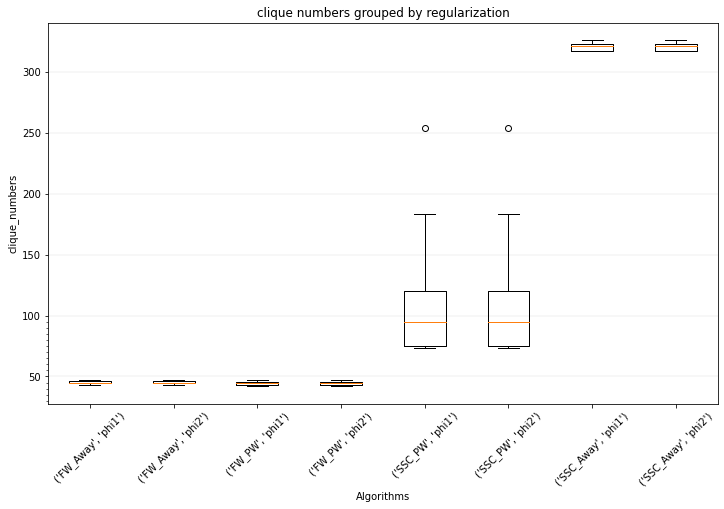

In [32]:
muxiter = pd.MultiIndex.from_product([algo_names, reg_list]) 
dfiter = pd.DataFrame(columns=pd.MultiIndex.from_product(
                         iterables=[algo_names, reg_list], 
                         names=["Algorithm", 'Regularization']))
#display(dfiter)
for algo in algo_names:
    dict_regular = {}
    for regular in reg_list:
        for test_name in test_results_reg[regular]:
            cpu_time_phi1 = list(test_results_reg[regular][test_name]['clique_number'][algo])
            #print(cpu_time_phi1)
            for index_i, i in enumerate(cpu_time_phi1):
                #row_list.append(i)
                dfiter.loc[index_i + 1, (algo, regular)] = i

#display(dfiter)
data_list = []
for algo in algo_names:
    for regular in reg_list:
        data_list.append(list(dfiter.loc[:, (algo, regular)]))

fig, ax = plt.subplots(figsize=(12, 7))
# Remove top and right border
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

ax.set_title('Regularization terms')

ax.set_title('clique numbers grouped by regularization')
ax.set_xlabel('Algorithms')
ax.set_ylabel('clique_numbers')
plt.xticks(rotation=45)
#ax.set_xlim([0,100])
#ax.set_xticks( np.arange(0,101,10), minor=False)
ax.set_yticks( np.arange(0,100,5),  minor=True)
ax.boxplot(data_list, labels=muxiter)
plt.show()

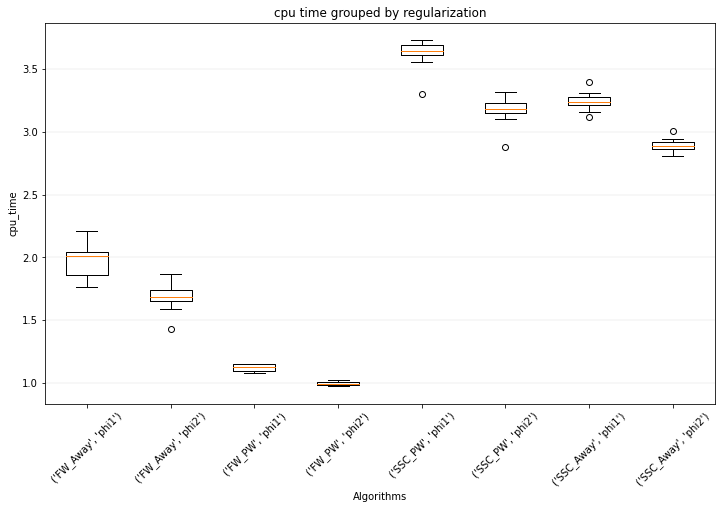

In [33]:
muxiter = pd.MultiIndex.from_product([algo_names, reg_list]) 
dfiter = pd.DataFrame(columns=pd.MultiIndex.from_product(
                         iterables=[algo_names, reg_list], 
                         names=["Algorithm", 'Regularization']))
#display(dfiter)
for algo in algo_names:
    dict_regular = {}
    for regular in reg_list:
        for test_name in test_results_reg[regular]:
            cpu_time_phi1 = list(test_results_reg[regular][test_name]['cpu_time'][algo])
            #print(cpu_time_phi1)
            for index_i, i in enumerate(cpu_time_phi1):
                #row_list.append(i)
                dfiter.loc[index_i + 1, (algo, regular)] = i

#display(dfiter)
data_list = []
for algo in algo_names:
    for regular in reg_list:
        data_list.append(list(dfiter.loc[:, (algo, regular)]))

fig, ax = plt.subplots(figsize=(12, 7))
# Remove top and right border
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

ax.set_title('Regularization terms')

ax.set_title('cpu time grouped by regularization')
ax.set_xlabel('Algorithms')
ax.set_ylabel('cpu_time')
plt.xticks(rotation=45)
#ax.set_xlim([0,100])
#ax.set_xticks( np.arange(0,101,10), minor=False)
ax.set_yticks( np.arange(0,100,5),  minor=True)
ax.boxplot(data_list, labels=muxiter)
plt.show()

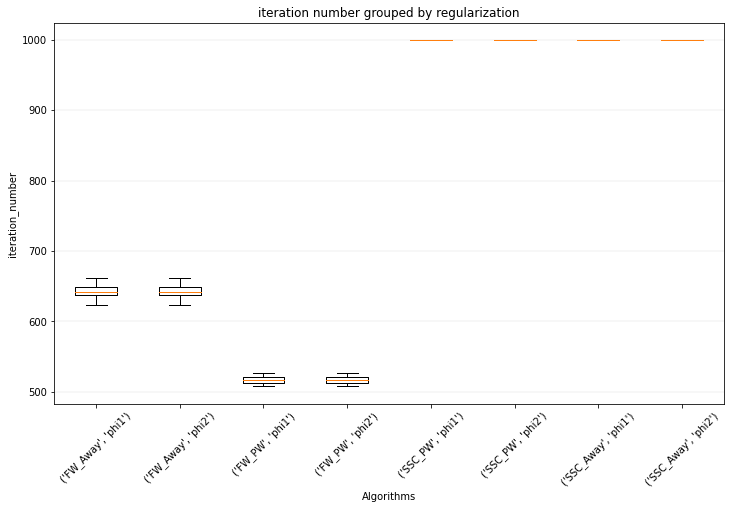

In [34]:
muxiter = pd.MultiIndex.from_product([algo_names, reg_list]) 
dfiter = pd.DataFrame(columns=pd.MultiIndex.from_product(
                         iterables=[algo_names, reg_list], 
                         names=["Algorithm", 'Regularization']))
#display(dfiter)
for algo in algo_names:
    dict_regular = {}
    for regular in reg_list:
        for test_name in test_results_reg[regular]:
            cpu_time_phi1 = list(test_results_reg[regular][test_name]['iteration_number'][algo])
            #print(cpu_time_phi1)
            for index_i, i in enumerate(cpu_time_phi1):
                #row_list.append(i)
                dfiter.loc[index_i + 1, (algo, regular)] = i

#display(dfiter)
data_list = []
for algo in algo_names:
    for regular in reg_list:
        data_list.append(list(dfiter.loc[:, (algo, regular)]))

fig, ax = plt.subplots(figsize=(12, 7))
# Remove top and right border
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

ax.set_title('Regularization terms')

ax.set_title('iteration number grouped by regularization')
ax.set_xlabel('Algorithms')
ax.set_ylabel('iteration_number')
plt.xticks(rotation=45)
#ax.set_xlim([0,100])
#ax.set_xticks( np.arange(0,101,10), minor=False)
ax.set_yticks(np.arange(0,100,5),  minor=True)
ax.boxplot(data_list, labels=muxiter)
plt.show()